In [1]:
import statistics
import cv2
import imutils
import math
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.lines as mlines

## Strip Detection & Comparison

This script takes a raw picture of the strips, detects the sensible regions of the strips, and compares all the strips with the right-most which is asummed to be the water control.

LOD tests

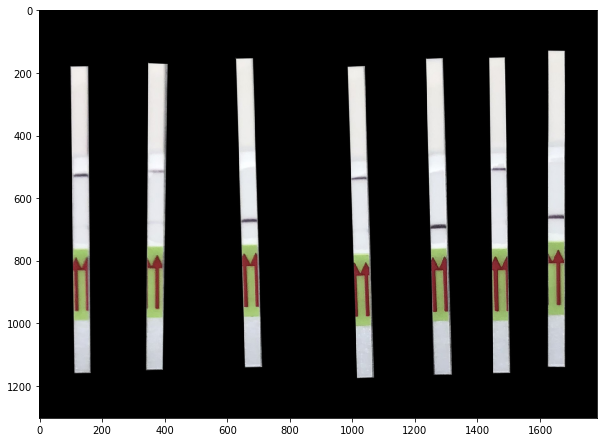

In [2]:
image_files = ['SL-IV-1.jpg',
               'N-II_lod_june20.jpg', 
               'NG_LOD.jpg', 
               'N2-LOD-Composite-black_background.jpg', 
               'N2_LOD_for_app_1_June202019.JPG',
               'N2_LOD_for_app_2_June202019.JPG',
               'EBOV-G2-LOD-dark.jpg']
filename = 'images/' + image_files[0]
image = cv2.imread(filename)
image = cv2.GaussianBlur(image, (5,5), 0)

fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [3]:
# Parameters

# The maximum and minimum allowed ratios of the sides of the green box
maxGreenBoxRatio = 140.0/528
minGreenBoxRatio = 102.0/578

# The maximum allowed ratio of the sides of the final deteted strip
maxStripBoxRatio = 70/480

# The maximum and minimum allowed ratios of the sides of the box defined by the red arrows
maxRedBoxRatio = 42.0/91
minRedBoxRatio = 14.0/104

# The maximum and minimum allowed ratios of the areas of green boxes and red arrow-bounding boxes
maxRedGreenBoxRatio = 3500.0/4000
minRedGreenBoxRatio = 2000.0/4500
# minRedGreenIntersection = 1000.0/4500

# White box strip ratio
# whiteBoxStripRatio = 160/1700.0

# The Y value above which the top of the strip should be 
# maxTopY = int(w * 0.2)

# Minimum intensity for binary thresholding of the top portion of the strips
minStripThreshold = 190

# Sensitive area of the strip
stripWidth = 200
stripHeight = 2000
stripHoldY = 900
# maxPeakAlign = 50

# Percentage of the margins to be removed
marginFraction = 0.2

# LOD Standard deviation obtained from low concentration samples 
LODStandardDeviation = 31
ThresholdFactor = 0.5

# Red is at the beginning/end of the hue range, so it covers the [0-15] and the [170, 180] 
# (hue in OpenCV varies  between 0 and 180 degrees)
lower_red1 = np.array([0, 50, 50]) 
upper_red1 = np.array([13, 255, 255])
lower_red2 = np.array([170, 50, 50]) 
upper_red2 = np.array([180, 255, 255])

# Green is between 20 and 90 (these ranges can be adjusted)
lower_green = np.array([20, 50, 50]) 
upper_green = np.array([83, 255, 255])

# We can also use a large color range to encapsulate both red and green:
lower_redgreen1 = np.array([0, 50, 50]) 
upper_redgreen1 = np.array([83, 255, 255])
lower_redgreen2 = np.array([170, 50, 50]) 
upper_redgreen2 = np.array([180, 255, 255])

In [4]:
# Some utilities

def makeOrderedBox(rect):
    """
    Return a 4-element tuple representing the corners of a box:
        idx 0 = top left corner   
        idx 1 = top right corner 
        idx 2 = bottom right corner
        idx 3 = botton left corner
    """
    box0 = cv2.boxPoints(rect)
    box0 = np.int0(box0)
    
    xval = [pt[0] for pt in box0]
    yval = [pt[1] for pt in box0]
    
    x0 = np.mean(xval)
    y0 = np.mean(yval)
  
    angles = []
    for i in range(0, len(box0)):
        xi = box0[i][0]
        yi = box0[i][1]        
        x = xi - x0
        y = yi - y0
        a = np.arctan2(y, x)
        val = [a, i]
        angles += [val]

    angles.sort(key=lambda val: val[0], reverse=False)    
    box = np.array([box0[val[1]] for val in angles])
    
    return box

def boxMinX(box):
    return min([pt[0] for pt in box])

def boxMaxX(box):  
    return max([pt[0] for pt in box])

def boxMinY(box):
    return min([pt[1] for pt in box])

def boxMaxY(box):
    return max([pt[1] for pt in box])

def boxArea(box):
    x0 = np.mean([pt[0] for pt in box])
    y0 = np.mean([pt[1] for pt in box])
    p0 = np.array([x0, y0])
    
    area = 0
    n = len(box)
    for i in range(0, n):
        p1 = box[i]
        if i < n - 1:
            p2 = box[i + 1]
        else:
            p2 = box[0]
            
        # Heron's Formula
        a = np.linalg.norm(p1-p0)
        b = np.linalg.norm(p2-p0)
        c = np.linalg.norm(p1-p2)
        s = (a + b + c) / 2
        triarea = np.sqrt(s * (s - a) * (s - b) * (s - c))
        
        area += triarea        
        
    return area

def rectArea(rect):
    return rect[1][0]*rect[1][1]

def pointDistance(p1, p2):
    """
    Given two poiints, each represented by a tuple (x1, y1), calculate the eucalidian distance
    between them.
    """
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

def boxesIntersection(box1, box2, img_shape):
    # Calculate the total intersection area of two boxes:
    
    # first sort the points in the boxes as (x,y) in descending order:
    box1.sort()
    box2.sort()
    
    blanked_image = np.zeros( shape = (img_shape[0], img_shape[1], 1), dtype = "uint8")
    cv2.drawContours(blanked_image, [box], 0, (255, 255, 255), thickness = -1)
    cv2.drawContours(blanked_image, [box], 0, (255, 255, 255), thickness = -1)
    
    return cv2.countNonZero(blanked_image)

def applyClahetoRGB(bgr_imb):
    
    lab= cv2.cvtColor(bgr_imb, cv2.COLOR_BGR2LAB)
    # Split lab image to different channels
    l, a, b = cv2.split(lab)
    
    # Apply CLAHE to L-channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    
    # Merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl,a,b))
    
    #Convert image from LAB Color model to RGB model
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return final

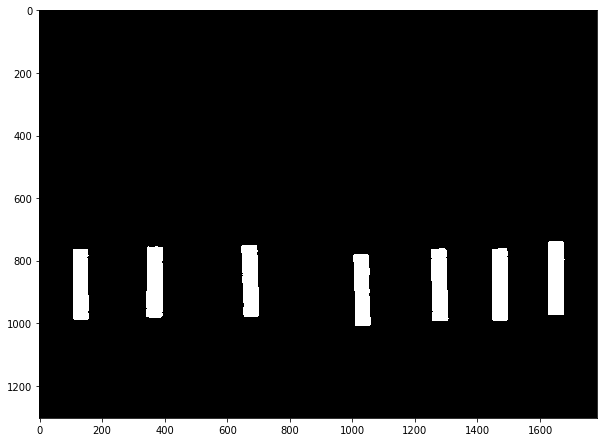

In [5]:
# Processing Step 1: detecting the colored area in the strips
image = cv2.imread(filename)
image = cv2.GaussianBlur(image, (5,5), 0)
# First, use CLAHE to improve image quality:
# plt.subplot(2, 1, 1)
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# image = applyClahetoRGB(image)
# plt.subplot(2, 1, 2)
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# First, convert the image to HSV color space, which makes the color detection straightforward
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# These strips have red arrows on a green background, so we define two masks, one for red and the other for green

red_mask1 = cv2.inRange(hsv, lower_red1, upper_red1) 
red_mask2 = cv2.inRange(hsv, lower_red2, upper_red2) 

kernel = np.ones((2,2),np.uint8)
red_mask = red_mask1 + red_mask2
green_mask = cv2.inRange(hsv, lower_green, upper_green)
redgreen_mask1 = cv2.inRange(hsv, lower_redgreen1, upper_redgreen1) 
redgreen_mask2 = cv2.inRange(hsv, lower_redgreen2, upper_redgreen2) 
mask = redgreen_mask1 + redgreen_mask2

fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB))

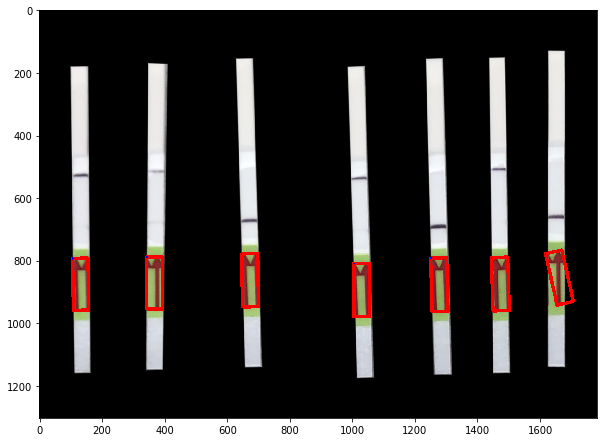

In [6]:
# Processing Step 2a: determining the bounding boxes for the red arrows.
# Because the red hue seems to be well-conserved between images,
# we have a high confidence of putting a box around all the red arrows. 

cnts = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# Create a copy of the original image to draw the bounding boxes on
tmp = image.copy()

red_boxes = []
red_rectangles = []
for c in cnts:
    M = cv2.moments(c)
    if M["m00"] == 0: continue
            
    rect = cv2.minAreaRect(c)
    box = makeOrderedBox(rect)
    
    # rect is a tuple with the following details:
    #    ( top-left corner(x,y),  (width,height),  angle of rotation )
    # As such, we can easily get the ratio of the sides of the detected boxes; note
    # that because for our purpose the sides are categorized into width and height
    # arbitrarily, we take the ratio of the sides as the lesser ratio:
    redBoxRatio = min(rect[1][0]/rect[1][1], rect[1][1]/rect[1][0])
    if redBoxRatio < minRedBoxRatio or maxRedBoxRatio < redBoxRatio: continue
    red_boxes += [box[0:]]
    red_rectangles += [rect]
     
    tmp = cv2.drawContours(tmp, [box], 0, (0,0,255), 10)
    tmp = cv2.circle(tmp, (box[0][0], box[0][1]), 3, (255,0,0), -1)

fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

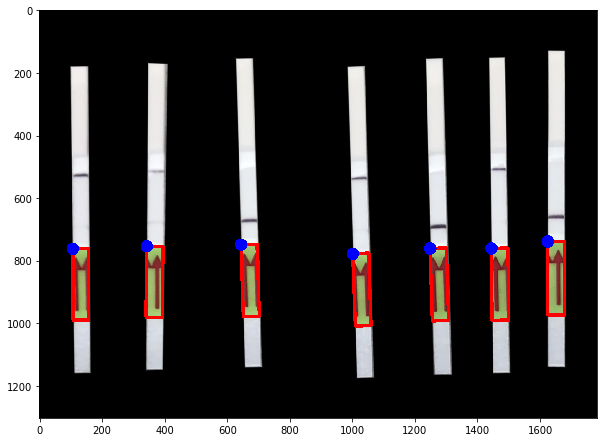

In [7]:
# Processing Step 2b: finding green box candidates
# Stage 1:
#     Given a masked version of the image which includes red to green hues,
#     find all green contours
# Stage 2:
#     Declare a green contour to be a green_rect_candidate to be further 
#     analyzed if the ratio of the sides of the contour are similar to that
#     observed in the Sherlock strips. 

cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# Create a copy of the original image to draw the bounding boxes on
tmp = image.copy()

green_box_candidates = []
green_rect_candidates = []
for c in cnts:
    M = cv2.moments(c)
    if M["m00"] == 0: continue
            
    rect = cv2.minAreaRect(c)
    box = makeOrderedBox(rect)
    
    # rect is a tuple with the following details:
    #    ( (x,y) of middle of top side of rect,  (width,height),  angle of rotation )
    # As such, we can easily get the ratio of the sides of the detected boxes; note
    # that because for our purpose the sides are categorized into width and height
    # arbitrarily, we take the ratio of the sides as the lesser ratio:
    greenBoxRatio = min(rect[1][0]/rect[1][1], rect[1][1]/rect[1][0])
    if greenBoxRatio < minGreenBoxRatio or maxGreenBoxRatio < greenBoxRatio: continue
        
    area = boxArea(box)
    green_box_candidates += [box[0:]]
    green_rect_candidates += [rect]
       
    tmp = cv2.drawContours(tmp, [box], 0, (0,0,255), 10)
    tmp = cv2.circle(tmp, (box[0][0], box[0][1]), 20, (255,0,0), -1)
    
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

12088.45512305823


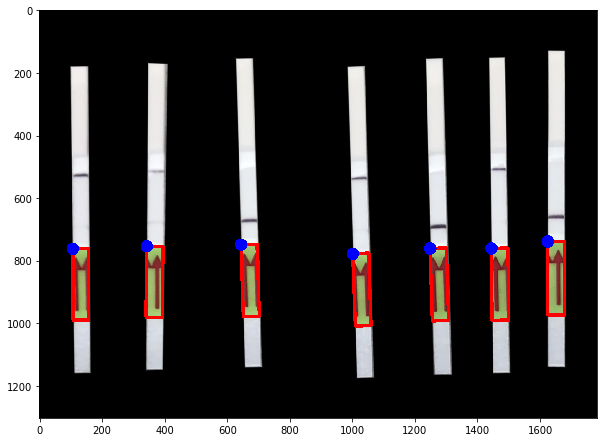

In [8]:
# Processing Step 2c: filter the green_box_candidates based on size (imputed from
# the red box areas) and shape (ratio of lengths of the sides).
# Stage 1:
#     Mark all candidate green boxes which are within a particular size range
#     of a red box. Because we can put bounding boxes around red arrows with a 
#     high confidence, and there is little-to-no red hue in the source image 
#     excluding the red arrows, we can impute that the largest of these marked
#     are the green boxes around the arrows (the contrary would suggest a large
#     green spot in the source image, or some severe hue errors)
# Stage 2:
#     Sort the marked boxes by size; chose the second largest marked box as a
#     representative green box
# Stage 3:
#     Filter out marked green boxes which are not a similar size as the
#     representative green box.
#
#

green_boxes = {}
green_rects = {}
for i, red_box in enumerate(red_boxes):
    red_box_area = boxArea(red_box)*1.0
    for j, green_box in enumerate(green_box_candidates):
        green_box_area = boxArea(green_box)*1.0
        redGreenBoxRatio = red_box_area/green_box_area
        if minRedGreenBoxRatio < redGreenBoxRatio < maxRedGreenBoxRatio:
            # now check for intersections:
            green_boxes[j] = True
            green_rects[j] = True
            
green_boxes = [green_box_candidates[j] for j in green_boxes]
green_rects = [green_rect_candidates[j] for j in green_rects]
green_boxes.sort(key = lambda box : boxArea(box), reverse=True)
green_rects.sort(key = lambda rect : rectArea(rect), reverse=True)

if len(green_rects) < 2:
    raise Exception('Not enough strips')
if rectArea(green_rects[0]) < 1.25* rectArea(green_rects[1]):
    greenBoxArea = rectArea(green_rects[1])
    green_rect_len = max(green_rects[1][1][0], green_rects[1][1][1])
elif len(green_boxes) < 3 \
        and rectArea(green_rects[1]) < 1.25* rectArea(green_rects[2]):
    greenBoxArea = rectArea(green_rects[2])
    green_rect_len = max(green_rects[2][1][0], green_rects[2][1][1])
else:
    raise Exception('Too much noise in image')

print(greenBoxArea)
center_boxes = [box for box in green_boxes 
                 if 0.8*greenBoxArea < boxArea(box) < 1.25*greenBoxArea]
greenBoxArea = statistics.median([boxArea(box) for box in center_boxes])

tmp = image.copy()
for box in center_boxes:
    tmp = cv2.drawContours(tmp, [box], 0, (0,0,255), 10)
    tmp = cv2.circle(tmp, (box[0][0], box[0][1]), 20, (255,0,0), -1)
    
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

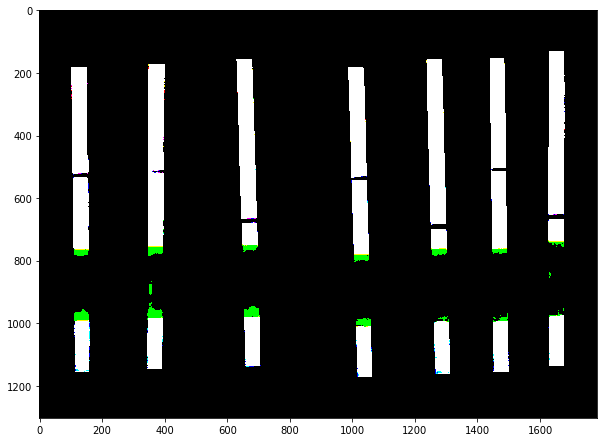

In [9]:
# Processing Step 3: binary thresholding of the entire image to extract the top part of the strips
ret, thresh = cv2.threshold(image, minStripThreshold, 255, cv2.THRESH_BINARY)

fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))

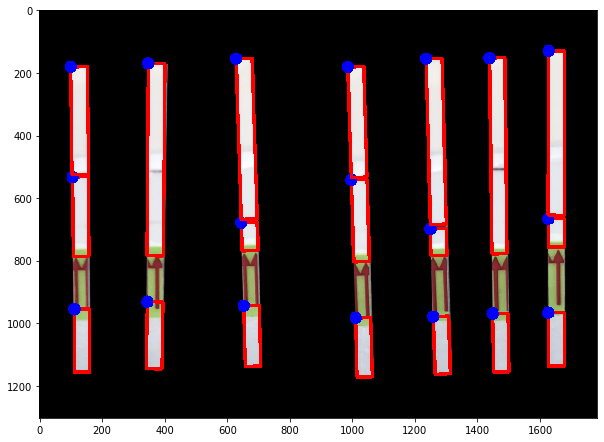

In [10]:
# Processing Step 4: detect boundary boxes for the top of the strips

grayscale = cv2.cvtColor(thresh, cv2.COLOR_BGR2GRAY)
cnts = cv2.findContours(grayscale, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# Create a copy of the original image to draw the bounding boxes on
tmp = image.copy()

# Minimum area of the top strip boxes
minTopBoxArea = 1.8 * greenBoxArea
# Maximum of the top strip boxes
maxTopBoxArea = 5 * greenBoxArea

top_box_candidates = []
top_rects_candidates = []
for c in cnts:
    M = cv2.moments(c)
    if M["m00"] == 0: continue
            
    rect = cv2.minAreaRect(c)
    box = makeOrderedBox(rect)
    
    area = boxArea(box)
    if area < minTopBoxArea/15 or maxTopBoxArea < area: 
        continue
        
#     if maxTopY < boxMinY(box): continue # Sameed edit: this should not be necessary. 

#     print("Found suitable top box")
    # print(rect)
    # print(area)    
    # print(box)
    top_box_candidates += [box]
    top_rects_candidates += [rect]
    
    tmp = cv2.drawContours(tmp, [box], 0, (0,0,255), 10)
    tmp = cv2.circle(tmp, (box[0][0], box[0][1]), 20, (255,0,0), -1)
    
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

7


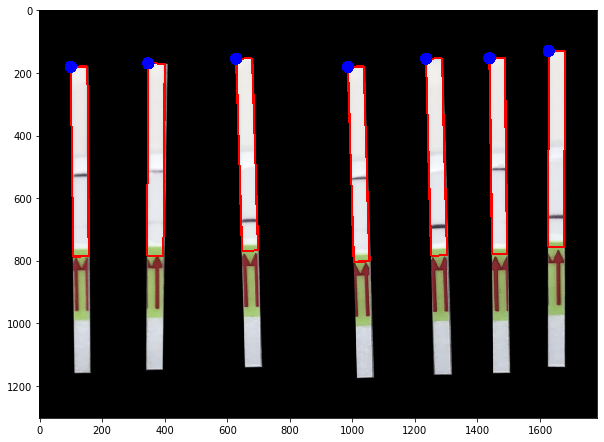

In [11]:
# In some cases, the strip signal is so strong that a continuous box gets split up into two boxes. 
# We fix this by merging two boxes if the bottom left and top left corners of the respective boxes,
# and the  right and top right corners of the respective boxes are within a threshold distance of
# # each other. 
top_boxes = []
top_box_candidates.sort(key = lambda item : item[1][1])
#print(top_box_candidates)
distance_threshold = green_rect_len * 0.15
merged_boxes = {}
tmp = image.copy()
for i in range(0, len(top_box_candidates)):
    upper_box = top_box_candidates[i]
    if i in merged_boxes:
        continue
    current_merged_upper_box = upper_box
    for j in range(i, len(top_box_candidates)):
        lower_box = top_box_candidates[j]
        if pointDistance(current_merged_upper_box[3], lower_box[0]) < distance_threshold and \
                pointDistance(current_merged_upper_box[2], lower_box[1]) < distance_threshold:
            # Sometimes the arrows get detected in this step as false boxes -- to filter for this, 
            # we make sure that boxes can only be concatenated if they have similar width:
            if pointDistance(current_merged_upper_box[3], current_merged_upper_box[2]) < \
                    pointDistance(lower_box[0], lower_box[1])*1.5:
                current_merged_upper_box = np.array([current_merged_upper_box[0], 
                                                     current_merged_upper_box[1], 
                                                     lower_box[2], lower_box[3]])

                if minTopBoxArea < boxArea(current_merged_upper_box): 
                    merged_boxes[j] =  True
    else:
        stripBoxRatio = pointDistance(current_merged_upper_box[0], 
                                      current_merged_upper_box[1])/ \
                                      pointDistance(current_merged_upper_box[0],
                                                    current_merged_upper_box[3])
        if minTopBoxArea < boxArea(current_merged_upper_box) and \
                stripBoxRatio < maxStripBoxRatio: 
            top_boxes.append(current_merged_upper_box) 

# print(top_boxes)
for box in top_boxes:
    tmp = cv2.drawContours(tmp, [box], 0, (0,0,255), 5)
    tmp = cv2.circle(tmp, (box[0][0], box[0][1]), 20, (255,0,0), -1)

print(len(top_boxes))

fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

In [12]:
# From:
# https://www.cs.hmc.edu/ACM/lectures/intersections.html
    
def intersectLines(pt1, pt2, ptA, ptB): 
    """ this returns the intersection of Line(pt1,pt2) and Line(ptA,ptB)
        
        returns a tuple: (xi, yi, valid, r, s), where
        (xi, yi) is the intersection
        r is the scalar multiple such that (xi,yi) = pt1 + r*(pt2-pt1)
        s is the scalar multiple such that (xi,yi) = pt1 + s*(ptB-ptA)
            valid == 0 if there are 0 or inf. intersections (invalid)
            valid == 1 if it has a unique intersection ON the segment    """

    DET_TOLERANCE = 0.00000001

    # the first line is pt1 + r*(pt2-pt1)
    # in component form:
    x1, y1 = pt1;   x2, y2 = pt2
    dx1 = x2 - x1;  dy1 = y2 - y1

    # the second line is ptA + s*(ptB-ptA)
    x, y = ptA;   xB, yB = ptB;
    dx = xB - x;  dy = yB - y;

    # we need to find the (typically unique) values of r and s
    # that will satisfy
    #
    # (x1, y1) + r(dx1, dy1) = (x, y) + s(dx, dy)
    #
    # which is the same as
    #
    #    [ dx1  -dx ][ r ] = [ x-x1 ]
    #    [ dy1  -dy ][ s ] = [ y-y1 ]
    #
    # whose solution is
    #
    #    [ r ] = _1_  [  -dy   dx ] [ x-x1 ]
    #    [ s ] = DET  [ -dy1  dx1 ] [ y-y1 ]
    #
    # where DET = (-dx1 * dy + dy1 * dx)
    #
    # if DET is too small, they're parallel
    #
    DET = (-dx1 * dy + dy1 * dx)

    if math.fabs(DET) < DET_TOLERANCE: return (0,0,0,0,0)

    # now, the determinant should be OK
    DETinv = 1.0/DET

    # find the scalar amount along the "self" segment
    r = DETinv * (-dy  * (x-x1) +  dx * (y-y1))

    # find the scalar amount along the input line
    s = DETinv * (-dy1 * (x-x1) + dx1 * (y-y1))

    # return the average of the two descriptions
    xi = (x1 + r*dx1 + x + s*dx)/2.0
    yi = (y1 + r*dy1 + y + s*dy)/2.0
    return ( xi, yi, 1, r, s )

def line(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0]*p2[1] - p2[0]*p1[1])
    return A, B, -C

def intersection(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return x,y
    else:
        return False

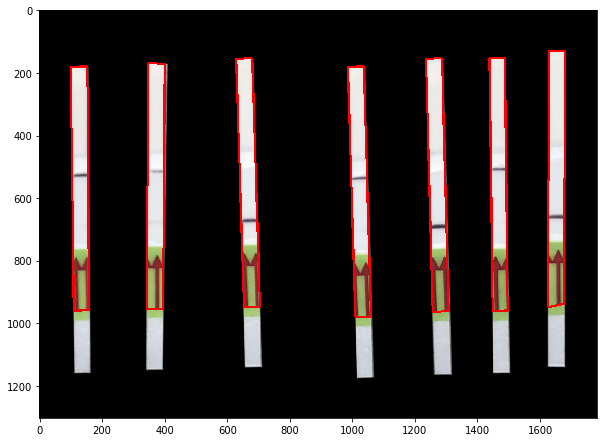

In [13]:
# Processing Step 5: construct the boxes that enclose the sensitive strip area

# First, order the top boxes from left to right
top_boxes.sort(key=lambda box: box[0][0], reverse=False)
# Find the red boxes which bound arrows, and then
# order them left to right
red_boxes.sort(key=lambda box: boxArea(box), reverse=True)
red_boxes = red_boxes[0:len(top_boxes)]
red_boxes.sort(key=lambda box: box[0][0], reverse=False)

# Create a copy of the original image to draw the bounding boxes on
tmp = image.copy()

num_boxes = len(top_boxes)

strip_boxes = []

for i in range(0, num_boxes):
    tbox = top_boxes[i]
    rbox = red_boxes[i]    

    # The corners are expected to be received in the following order:
    # 0 = botton left corner
    # 1 = top left corner   
    # 2 = top right corner 
    # 3 = bottom right corner
        
    tp0, tp1, tp2, tp3 = tbox[3], tbox[0], tbox[1], tbox[2]
    rp0, rp1, rp2, rp3 = rbox[3], rbox[0], rbox[1], rbox[2]
    
    # The intersection of the lines defining the sides of the strip (tp1-tp0 and tp2-tp3)
    # with the bottom edge of the red box defines the bottom corners of the area of interest
    res1 = intersection(line(tp1, tp0), line(rp0, rp3))
    res2 = intersection(line(tp2, tp3), line(rp0, rp3)) 
    
    assert(res1 != False and res2 != False), "Top and center boxes are not intersecting"
    
    p1 = np.array([int(round(res1[0])), int(round(res1[1]))])
    p2 = np.array([int(round(res2[0])), int(round(res2[1]))])
    
    sbox = np.array([p1, tp1, tp2, p2])
# #     sbox = np.array([cp1, tp1, tp2, cp2])

    strip_boxes += [sbox]
    tmp = cv2.drawContours(tmp, [sbox], 0, (0, 0, 255), 5)

fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

In [14]:
def rotate_image(img, center, angle, width, height):

   shape = (img.shape[1], img.shape[0]) # (length, height)

   matrix = cv2.getRotationMatrix2D((center[0], center[1]), angle, 1 )
   rotated = cv2.warpAffine( img, matrix, shape )

   x = int( center[0] - width/2  )
   y = int( center[1] - height/2 )

   cropped = rotated[ y:y+height, x:x+width ]

   return cropped

-0.736409055459295
53
0.3654018031374991
53
-1.8057001616667454
51
-1.722662071622803
51
-1.4887878246854704
51
-0.7090699805243126
49
0.0699581819781259
51


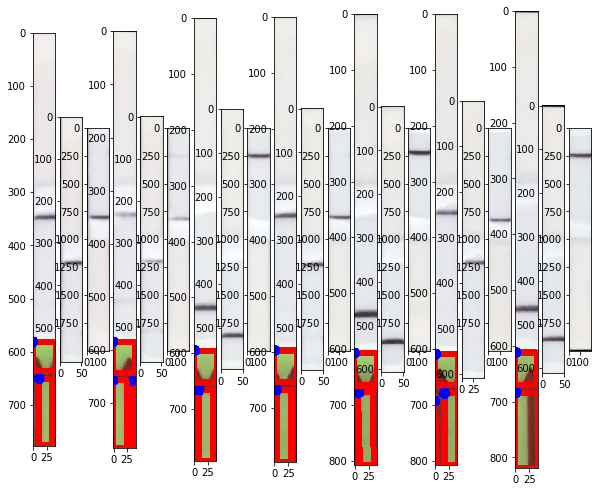

In [15]:
# Processing Step 6: Extract the strips into separate images

ref_box = np.array([[0, 0],[0, stripHeight],[stripWidth, stripHeight],[stripWidth, 0]], dtype=float)

lower_green = np.array([20, 50, 50]) 
upper_green = np.array([83, 255, 255])

fig, plots = plt.subplots(1, len(strip_boxes)*3, figsize=(10, 10))
idx = 0
tmp = image.copy()
raw_strip_images = []
for sbx in strip_boxes:
    center = (statistics.mean([sbx[0][0], sbx[1][0], sbx[2][0], sbx[3][0]]),
              statistics.mean([sbx[0][1], sbx[1][1], sbx[2][1], sbx[3][1]]))
    angle = -1*np.degrees(np.arctan2(sbx[0][0]-sbx[1][0], sbx[0][1] - sbx[1][1]))
    #angle = angle if sbx[0][0] < sbx[1][0] else angle*-1
    width = int(pointDistance(sbx[1], sbx[2]))
    height = int(pointDistance(sbx[0], sbx[1]))
    print(angle)
    print(width)
    straigtened_strip = rotate_image(image, center, angle, width, 
                                                height)
    # Spurious hits often occur at the edges of the strip, so let's
    # crop them away
    cropped_strip = straigtened_strip[:, 
                                      int(straigtened_strip.shape[1]*0.1):
                                      int(straigtened_strip.shape[1]*0.9)]
    
    plots[idx].imshow(cv2.cvtColor(cropped_strip, cv2.COLOR_BGR2RGB))
                      
    hsv = cv2.cvtColor(cropped_strip, cv2.COLOR_BGR2HSV)
    green_mask = cv2.inRange(hsv, lower_green, upper_green)
    cnts = cv2.findContours(green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    # Create a copy of the image to draw the bounding boxes on
    tmp = cropped_strip.copy()
    colored_box_cutoff = tmp.shape[0]
    for c in cnts:
        M = cv2.moments(c)
        if M["m00"] == 0: continue

        rect = cv2.minAreaRect(c)
        box = makeOrderedBox(rect)
        if boxArea(box) > 0.10*greenBoxArea:
            if box[0][1] < colored_box_cutoff:
                colored_box_cutoff = box[0][1]
        tmp = cv2.drawContours(tmp, [box], 0, (0,0,255), 10)
        tmp = cv2.circle(tmp, (box[0][0], box[0][1]), 10, (255,0,0), -1)
    #plots[idx + 0].imshow(cv2.cvtColor(green_mask, cv2.COLOR_BGR2RGB))
    plots[idx + 0].imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))
    
    colored_box_cutoff = colored_box_cutoff
    final_strip = straigtened_strip[0:colored_box_cutoff, :]
    plots[idx + 1].imshow(cv2.cvtColor(final_strip, cv2.COLOR_BGR2RGB))
#     h, status = cv2.findHomography(final_strip, ref_box)
#     img = cv2.warpPerspective(image, h, (stripWidth, stripHeight))
#     raw_strip_images += [img]
    height = final_strip.shape[0]
    width = final_strip.shape[1]
    h, status = cv2.findHomography(np.array([(0,height), (0,0), (width, 0), (width, height)]), ref_box)
    img = cv2.warpPerspective(final_strip, h, (stripWidth, stripHeight))
    raw_strip_images += [img]
    plots[idx + 2].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    idx += 3

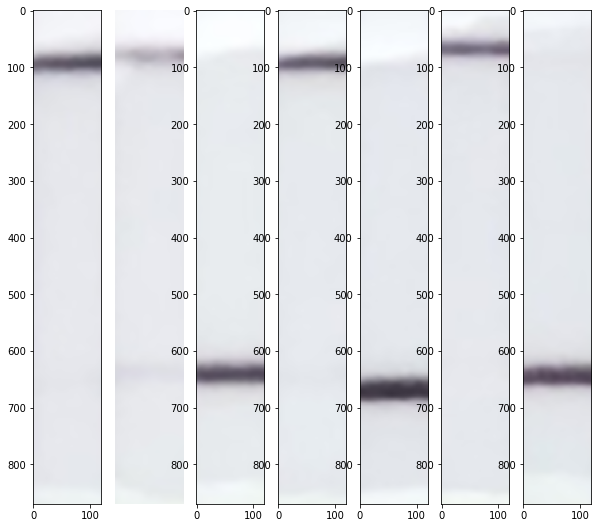

In [16]:
# Processing Step 7: Crop the images to remove the grip of the strips, and the vertical borders

norm_strip_images = []

fig, plots = plt.subplots(1, len(raw_strip_images), figsize=(10, 10))
idx = 0
for img in raw_strip_images:
    # Crop out the top and the bottom parts of the strip, and applying bilateral filtering for smoothing
    # https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_filtering/py_filtering.html
    x0 = int(marginFraction * stripWidth)
    x1 = int((1 - marginFraction) * stripWidth)
    y0 = 0
    y1 = stripHoldY

    crop = img[y0:y1, x0:x1]
    nimg = cv2.bilateralFilter(crop, 9, 75, 75)
    nimg = nimg[30:, :]
    norm_strip_images += [nimg]
    
    vimg = cv2.flip(nimg, 0)
    if idx == 1: plots[idx].axis('off')
    plots[idx].imshow(cv2.cvtColor(vimg, cv2.COLOR_BGR2RGB))
    idx += 1

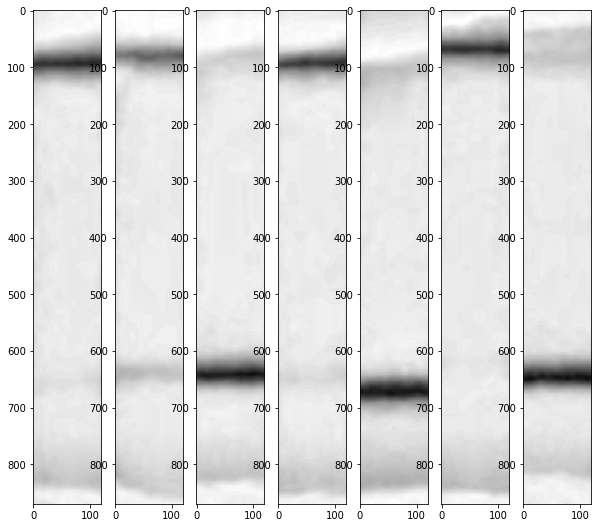

In [17]:
# Processing Step 7b: Normalize HSV values
correction_method = 'clahe' # {'linear', 'clahe', 'gray', 'he'}
fig, plots = plt.subplots(1, len(raw_strip_images), figsize=(10, 10))
idx = 0
hew_corrected_norm_strip_images = []
for nimg in norm_strip_images:
    hsv = cv2.cvtColor(nimg, cv2.COLOR_BGR2HSV)
    # determine the hsv color of this strip
    if correction_method == 'linear':
        # We chose a standard hsv value to normalize all of our images to:
        standard_hsv = [16.0/1.5, 17.0/1.5, 243.0/1.5]
        # standard_hsv = [16.0, 17.0, 243.0]

        rows_hsv = []
        for i in range(hsv.shape[0]):
            pixels_h = np.zeros(hsv.shape[1])
            pixels_s = np.zeros(hsv.shape[1])
            pixels_v = np.zeros(hsv.shape[1])
            for j in range(hsv.shape[1]):
                pixels_h[j] = hsv[i,j][0]
                pixels_s[j] = hsv[i,j][1]
                pixels_v[j] = hsv[i,j][2]
            rows_hsv.append([statistics.median(val) for val in [pixels_h, pixels_s, pixels_v]])
            #print(rows_hsv)
        rows_hsv = np.array(rows_hsv)
        strip_hsv = [statistics.median(rows_hsv[:,0]), 
                           statistics.median(rows_hsv[:,1]),
                           statistics.median(rows_hsv[:,2])]
        hue_correction = standard_hsv[0]/strip_hsv[0]
        sat_correction = standard_hsv[1]/strip_hsv[1]
        val_correction = standard_hsv[2]/strip_hsv[2]
        for i in range(hsv.shape[0]):
            for j in range(hsv.shape[1]):
                # hsv[i,j][0] = min(179, hsv[i,j][0] * hue_correction)
                hsv[i,j][0] = min(180, hsv[i,j][0] * hue_correction)
                hsv[i,j][1] = hsv[i,j][1] * sat_correction
                hsv[i,j][2] = hsv[i,j][2] * val_correction
        hew_corrected_norm_strip_images.append(cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR))
        vimg = cv2.flip(hew_corrected_norm_strip_images[-1],0)
        vimg_color = cv2.COLOR_BGR2RGB
    
    elif correction_method == 'clahe':
        clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(10,10))
        hew_corrected_norm_strip_images.append(clahe.apply(cv2.cvtColor(nimg, cv2.COLOR_BGR2GRAY)))
        vimg = cv2.flip(hew_corrected_norm_strip_images[-1],0)
        vimg_color = cv2.COLOR_GRAY2RGB        
        
    elif correction_method == 'he':
        hew_corrected_norm_strip_images.append(
            cv2.equalizeHist(cv2.cvtColor(nimg, cv2.COLOR_BGR2GRAY)))
        vimg = cv2.flip(hew_corrected_norm_strip_images[-1],0)
        vimg_color = cv2.COLOR_GRAY2RGB
        
    elif correction_method == 'gray':
        hew_corrected_norm_strip_images.append(cv2.cvtColor(nimg, cv2.COLOR_BGR2GRAY))
        vimg = cv2.flip(hew_corrected_norm_strip_images[-1],0)
        vimg_color = cv2.COLOR_GRAY2RGB
        
    else:
        raise Exception('incorrect normalization type')
    
    plots[idx].imshow(cv2.cvtColor(vimg, vimg_color))
#     plots[idx].imshow(vimg)
    
    idx += 1

Threshold: 195.54166666666666


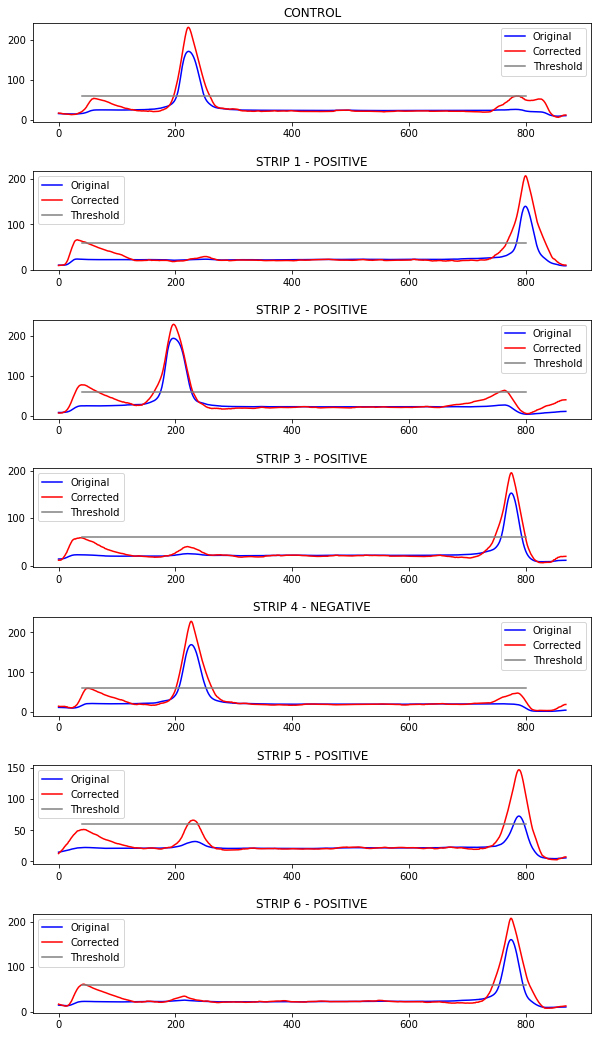

In [18]:
# Processing Step 8: Plot raw intensities, and make prediction using "universal" threshold
def getmin(data):
    half = int(data.shape[0]/2)
    top = data.shape[0]
    values = np.array([])
    for i in range(half, top):
        values = np.append(values, np.mean(data[i]))
    m = np.min(values)
    sd = np.std(values)
    return m, sd

# Naive prediction using threshold obtained from set of controls and low concentration samples
def predict(data, threshold):
    m, sd = getmin(data)     
    if m < threshold: return "POSITIVE"
#     if m < LODThreshold: return "POSITIVE"
#     elif m < LODThreshold + 2 * sd: return "BORDERLINE"
    else: return "NEGATIVE"

fig, plots = plt.subplots(len(norm_strip_images), figsize=(10, 10))
plt.subplots_adjust(top=1.5, hspace=0.5)
idx = len(norm_strip_images) - 1
legend_info = []
for img in norm_strip_images:
    data = img.astype('int32') 
    nrows = data.shape[0]
    values = np.array([])
    for r in range(0, nrows):
        values = np.append(values, 255 - np.mean(data[r]))    
    natural = plots[idx].plot(values, 'b')        
    idx -= 1

# repeat above for images with corected hue

# Calculate threshold from corrected control image
idx = len(norm_strip_images) - 1
min0 = 0
img0 = hew_corrected_norm_strip_images[idx]
data0 = img0.astype('int32')
min0, _ = getmin(data0)
threshold = min0 - (ThresholdFactor - 0.5) * 2 * LODStandardDeviation
print("Threshold:", threshold)

for img in hew_corrected_norm_strip_images:
    data = img.astype('int32') 
    nrows = data.shape[0]
    values = np.array([])
    for r in range(0, nrows):
        values = np.append(values, 255 - np.mean(data[r]))    
    corrected = plots[idx].plot(values,'r')
    if idx == 0:
        plots[idx].set_title("CONTROL")
        legend_info.append(corrected)
    else:
        pred = predict(data, min0)
        plots[idx].set_title("STRIP " + str(idx) + " - " + pred)
    plots[idx].plot([40, 800], [255 - threshold, 255 - threshold], 'k-', color='grey')
    blue_line = mlines.Line2D([], [], color='blue', label='Original')
    red_line = mlines.Line2D([], [], color='red', label='Corrected')
    grey_line = mlines.Line2D([], [], color='grey', label='Threshold')
    plots[idx].legend(handles=[blue_line, red_line, grey_line])        
    idx -= 1